In [ ]:
!pip install -q scikit-learn matplotlib pandas transformers

In [43]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define constants
experiment = "fixed_1e7_2"
EVAL_CSV_FILE_PATH = f"{experiment}/lr_dependency_results_scaled_eval.csv"
MAIN_CSV_FILE_PATH = f"{experiment}/lr_dependency_results_scaled.csv"
OUTPUT_FOLDER = f"{experiment}/analysis_output"
FIXED_LR = 5e-6  # Define the fixed learning rate for the vertical line
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Function to get the min and max range for x and y axis
def get_y_axis_range(csv_file_paths):
    all_losses = []
    
    for csv_file_path in csv_file_paths:
        df = pd.read_csv(csv_file_path)
        df = df[pd.to_numeric(df['LR'], errors='coerce').notnull()]
        df['LR'] = df['LR'].astype(float)
        all_losses.extend(df['Inference Loss'].values)
    
    y_min, y_max = min(all_losses), max(all_losses)
    
    return y_min, y_max

# Function to get the global min and max for MAD values
def get_mad_axis_range(csv_file_paths):
    all_mad_values = []
    all_grad_mad_values = []
    
    for csv_file_path in csv_file_paths:
        df = pd.read_csv(csv_file_path)
        df = df[pd.to_numeric(df['LR'], errors='coerce').notnull()]
        df['LR'] = df['LR'].astype(float)
        all_mad_values.extend(df['Overall MAD'].values)
        all_grad_mad_values.extend(df['Overall Gradient MAD'].values)
    
    mad_min, mad_max = min(all_mad_values), max(all_mad_values)
    grad_mad_min, grad_mad_max = min(all_grad_mad_values), max(all_grad_mad_values)
    
    return min(mad_min, grad_mad_min), max(mad_max, grad_mad_max)

# Function to average MAD values for repeated learning rates
def average_mad_values(df):
    mad_columns = ['Overall MAD', 'Overall Gradient MAD']
    df_mad_avg = df.groupby('LR')[mad_columns].mean().reset_index()
    df_non_mad = df.drop(columns=mad_columns).drop_duplicates(subset='LR')
    return pd.merge(df_non_mad, df_mad_avg, on='LR')

# Function to analyze CSV data and plot learning rate vs. loss
def analyze_and_plot(csv_file_path, model_name, output_folder, show_plot=True, add_fixed_lr=True, x_range=(1e-9, 1e-2), y_values=None, mad_y_values=None):
    df = pd.read_csv(csv_file_path)
    
    # Separate fixed LR rows
    fixed_lr_df = df[df['LR'] == 'fixed']
    
    # Ensure Learning Rate is a float, ignoring non-numeric rows
    df = df[pd.to_numeric(df['LR'], errors='coerce').notnull()]
    df['LR'] = df['LR'].astype(float)
    
    # Average duplicate fixed LR values
    if not fixed_lr_df.empty:
        fixed_lr_df = fixed_lr_df.groupby(['Epoch']).mean().reset_index()
    
    for epoch in df['Epoch'].unique():
        epoch_df = df[df['Epoch'] == epoch]
        
        # Handle fixed LR points
        if add_fixed_lr and not fixed_lr_df.empty:
            epoch_fixed_lr_df = fixed_lr_df[fixed_lr_df['Epoch'] == epoch]
            if not epoch_fixed_lr_df.empty:
                epoch_fixed_lr = epoch_fixed_lr_df.iloc[0]
                epoch_fixed_lr_point = pd.DataFrame([{'LR': FIXED_LR, 'Inference Loss': epoch_fixed_lr['Inference Loss'], 'Train Loss': epoch_fixed_lr['Train Loss'], 'Overall MAD': epoch_fixed_lr['Overall MAD'], 'Overall Gradient MAD': epoch_fixed_lr['Overall Gradient MAD'], 'Epoch': epoch}])
                epoch_df = epoch_df[epoch_df['LR'] != FIXED_LR]  # Remove any existing FIXED_LR points
                epoch_df = pd.concat([epoch_df, epoch_fixed_lr_point], ignore_index=True)
        
        epoch_df = epoch_df.sort_values(by='LR')
        
        # Average MAD values for repeated learning rates
        epoch_df = average_mad_values(epoch_df)
        
        fig, ax1 = plt.subplots(figsize=(12, 6))
        
        ax1.plot(epoch_df['LR'], epoch_df['Inference Loss'], 'b^-', label='Inference Loss')
        
        best_lr = epoch_df.loc[epoch_df['Inference Loss'].idxmin(), 'LR']
        best_loss = epoch_df['Inference Loss'].min()
        train_loss = epoch_df['Train Loss'].iloc[0]  # Assuming train loss is constant for the entire epoch
        
        ax1.set_xscale('log')
        ax1.set_yscale('log')
        ax1.set_xlabel('Learning Rate (log scale)')
        ax1.set_ylabel('Loss (log scale)')
        ax1.set_title(f'{model_name} - Epoch {epoch}: Inference Loss vs Learning Rate')
        ax1.axhline(y=train_loss, color='purple', linestyle='-', label=f'Train Loss = {train_loss:.2f}')
        
        ax2 = ax1.twinx()
        
        # Interpolate missing values to ensure continuity
        epoch_df['Overall MAD'] = epoch_df['Overall MAD'].interpolate()
        epoch_df['Overall Gradient MAD'] = epoch_df['Overall Gradient MAD'].interpolate()
        
        ax2.plot(epoch_df['LR'], epoch_df['Overall MAD'], 'gs-', label='Layer MAD')
        ax2.plot(epoch_df['LR'], epoch_df['Overall Gradient MAD'], 'mo-', label='Gradient MAD')
        ax2.set_yscale('log')
        ax2.set_ylabel('MAD Values (log scale)')
        
        # Ensure the best LR dot is on top
        ax1.scatter([best_lr], [best_loss], color='orange', s=100, zorder=10, label=f'Best LR: {best_lr:.2e}\nLoss: {best_loss:.2f}')
        
        # Add the fixed LR point as a cyan dot
        if add_fixed_lr and not epoch_fixed_lr_df.empty:
            ax1.scatter([FIXED_LR], [epoch_fixed_lr['Inference Loss']], color='cyan', s=100, zorder=10, label=f'Fixed LR: {FIXED_LR:.2e}\nLoss: {epoch_fixed_lr["Inference Loss"]:.2f}')
        
        # Add vertical line for fixed LR
        ax1.axvline(x=FIXED_LR, color='black', linestyle='--', label=f'Fixed LR = {FIXED_LR:.2e}')
        
        # Combine legends
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
        
        fig.tight_layout(rect=[0, 0.1, 1, 0.95])
        
        ax1.set_xlim(x_range)
        ax1.set_ylim(y_values[0], y_values[-1])
        ax1.set_yticks(y_values)
        ax1.set_yticklabels([f'{y:.2f}' for y in y_values])

        ax2.set_ylim(mad_y_values[0], mad_y_values[-1])
        ax2.set_yticks(mad_y_values)
        ax2.set_yticklabels([f'{y:.2e}' for y in mad_y_values])
        
        plot_path = os.path.join(output_folder, f'{model_name.lower().replace(" ", "_")}_epoch_{epoch}_loss_vs_lr.png')
        plt.savefig(plot_path, bbox_inches='tight')
        print(f'{model_name} - Epoch {epoch} plot saved to {plot_path}')
        
        plt.close()

def main(plot_eval=True, add_fixed_lr=True):
    csv_file_paths = [MAIN_CSV_FILE_PATH]
    if plot_eval:
        csv_file_paths.append(EVAL_CSV_FILE_PATH)
    
    y_min, y_max = get_y_axis_range(csv_file_paths)
    y_values = np.logspace(np.log10(y_min), np.log10(y_max), num=15)
    
    mad_min, mad_max = get_mad_axis_range(csv_file_paths)
    mad_y_values = np.logspace(np.log10(mad_min), np.log10(mad_max), num=15)
    
    if plot_eval:
        analyze_and_plot(EVAL_CSV_FILE_PATH, "Evaluation Model", OUTPUT_FOLDER, add_fixed_lr=add_fixed_lr, y_values=y_values, mad_y_values=mad_y_values)
    analyze_and_plot(MAIN_CSV_FILE_PATH, "Main Model", OUTPUT_FOLDER, add_fixed_lr=add_fixed_lr, y_values=y_values, mad_y_values=mad_y_values)

if __name__ == "__main__":
    main(plot_eval=False, add_fixed_lr=False)


Main Model - Epoch 1 plot saved to fixed_1e7_2/analysis_output/main_model_epoch_1_loss_vs_lr.png
Main Model - Epoch 2 plot saved to fixed_1e7_2/analysis_output/main_model_epoch_2_loss_vs_lr.png
Main Model - Epoch 3 plot saved to fixed_1e7_2/analysis_output/main_model_epoch_3_loss_vs_lr.png
Main Model - Epoch 4 plot saved to fixed_1e7_2/analysis_output/main_model_epoch_4_loss_vs_lr.png
Main Model - Epoch 5 plot saved to fixed_1e7_2/analysis_output/main_model_epoch_5_loss_vs_lr.png
Main Model - Epoch 6 plot saved to fixed_1e7_2/analysis_output/main_model_epoch_6_loss_vs_lr.png
Main Model - Epoch 7 plot saved to fixed_1e7_2/analysis_output/main_model_epoch_7_loss_vs_lr.png
Main Model - Epoch 8 plot saved to fixed_1e7_2/analysis_output/main_model_epoch_8_loss_vs_lr.png
Main Model - Epoch 9 plot saved to fixed_1e7_2/analysis_output/main_model_epoch_9_loss_vs_lr.png
Main Model - Epoch 10 plot saved to fixed_1e7_2/analysis_output/main_model_epoch_10_loss_vs_lr.png


Total number of unique learning rates in the LR column: 12
Number of unique learning rates after filtering: 12
Plot saved to fixed_1e7_2/layer_mad_over_epochs.png


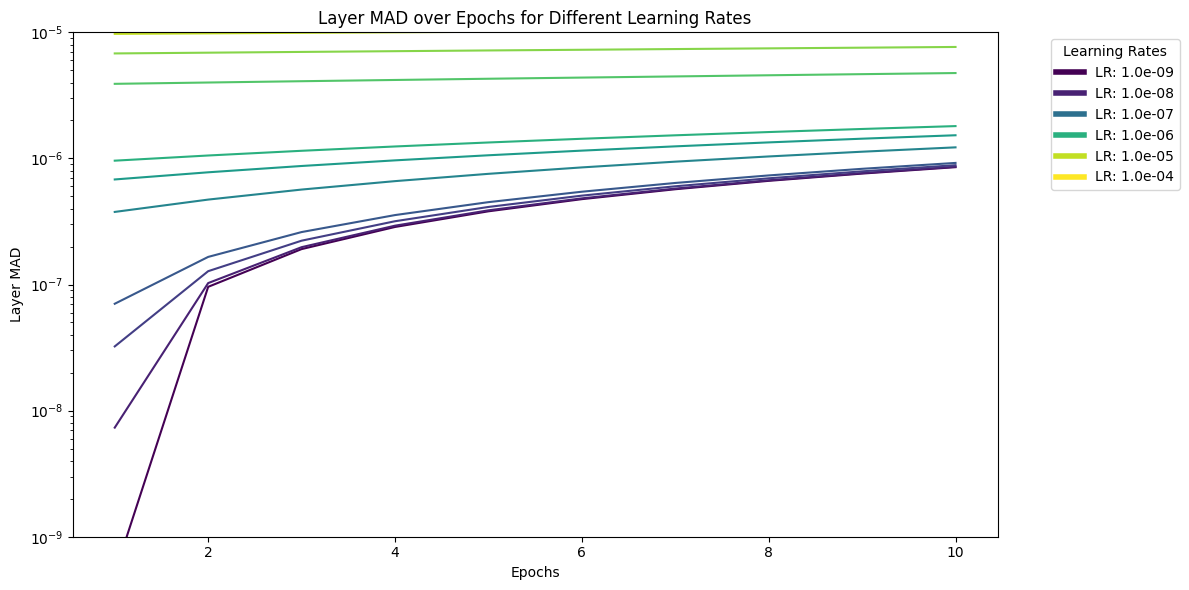

In [44]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Constants
EXPERIMENT = "fixed_1e7_2"
MAIN_CSV_FILE_PATH = f"{EXPERIMENT}/lr_dependency_results_scaled.csv"
OUTPUT_FOLDER = f"{EXPERIMENT}/"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Function to filter learning rates
def filter_learning_rates(df):
    df = df[pd.to_numeric(df['LR'], errors='coerce').notnull()]
    df['LR'] = df['LR'].astype(float)
    return df

# Function to plot Layer MAD over epochs for all learning rates
def plot_layer_mad_over_epochs(csv_file_path, output_folder):
    df = pd.read_csv(csv_file_path)
    unique_lrs_total = len(df['LR'].unique())
    df = filter_learning_rates(df)
    unique_lrs_filtered = len(df['LR'].unique())
    
    print(f"Total number of unique learning rates in the LR column: {unique_lrs_total}")
    print(f"Number of unique learning rates after filtering: {unique_lrs_filtered}")
    
    learning_rates = sorted(df['LR'].unique())
    num_colors = len(learning_rates)
    colors = plt.cm.viridis(np.linspace(0, 1, num_colors))
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for lr, color in zip(learning_rates, colors):
        lr_df = df[df['LR'] == lr]
        if lr_df.empty:
            continue
        ax.plot(lr_df['Epoch'], lr_df['Overall MAD'], label=f'LR: {lr:.1e}', color=color)
    
    # Select learning rates for the legend, one for each power of ten
    learning_rates_array = np.array(learning_rates)
    powers_of_ten = [10**i for i in range(int(np.log10(min(learning_rates))), int(np.log10(max(learning_rates))) + 1)]
    legend_indices = [np.abs(learning_rates_array - lr).argmin() for lr in powers_of_ten]
    handles = [plt.Line2D([0], [0], color=colors[i], lw=4) for i in legend_indices]
    labels = [f'LR: {learning_rates[i]:.1e}' for i in legend_indices]
    
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Layer MAD')
    ax.set_title('Layer MAD over Epochs for Different Learning Rates')
    ax.legend(handles, labels, title='Learning Rates', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_yscale('log')
    
    # Set y-axis limits
    ax.set_ylim(1e-9, 1e-5)
    
    plt.tight_layout()
    plot_path = os.path.join(output_folder, 'layer_mad_over_epochs.png')
    plt.savefig(plot_path, bbox_inches='tight')
    print(f'Plot saved to {plot_path}')
    plt.show()

def main():
    plot_layer_mad_over_epochs(MAIN_CSV_FILE_PATH, OUTPUT_FOLDER)

if __name__ == "__main__":
    main()


Total number of unique learning rates in the LR column: 12
Number of unique learning rates after filtering: 12
Plot saved to fixed_1e7_2/gradient_mad_over_epochs.png


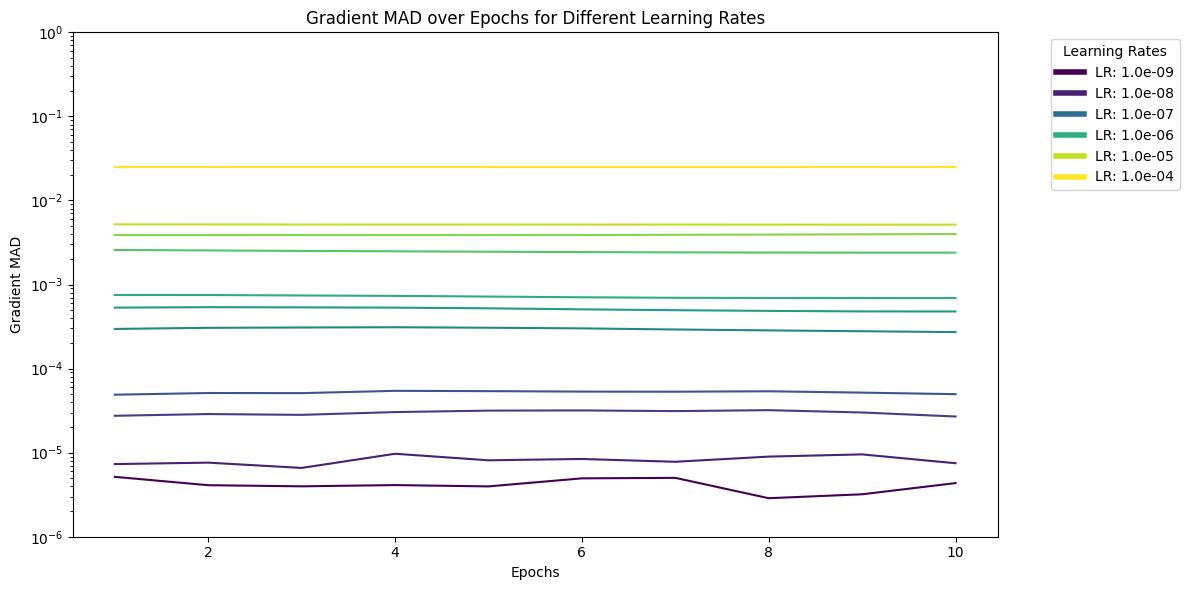

In [45]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Constants
EXPERIMENT = "fixed_1e7_2"
MAIN_CSV_FILE_PATH = f"{EXPERIMENT}/lr_dependency_results_scaled.csv"
OUTPUT_FOLDER = f"{EXPERIMENT}/"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Function to filter learning rates
def filter_learning_rates(df):
    df = df[pd.to_numeric(df['LR'], errors='coerce').notnull()]
    df['LR'] = df['LR'].astype(float)
    return df

# Function to plot Gradient MAD over epochs for all learning rates
def plot_gradient_mad_over_epochs(csv_file_path, output_folder):
    df = pd.read_csv(csv_file_path)
    unique_lrs_total = len(df['LR'].unique())
    df = filter_learning_rates(df)
    unique_lrs_filtered = len(df['LR'].unique())
    
    print(f"Total number of unique learning rates in the LR column: {unique_lrs_total}")
    print(f"Number of unique learning rates after filtering: {unique_lrs_filtered}")
    
    learning_rates = sorted(df['LR'].unique())
    num_colors = len(learning_rates)
    colors = plt.cm.viridis(np.linspace(0, 1, num_colors))
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for lr, color in zip(learning_rates, colors):
        lr_df = df[df['LR'] == lr]
        if lr_df.empty:
            continue
        ax.plot(lr_df['Epoch'], lr_df['Overall Gradient MAD'], label=f'LR: {lr:.1e}', color=color)
    
    # Select learning rates for the legend, one for each power of ten
    learning_rates_array = np.array(learning_rates)
    powers_of_ten = [10**i for i in range(int(np.log10(min(learning_rates))), int(np.log10(max(learning_rates))) + 1)]
    legend_indices = [np.abs(learning_rates_array - lr).argmin() for lr in powers_of_ten]
    handles = [plt.Line2D([0], [0], color=colors[i], lw=4) for i in legend_indices]
    labels = [f'LR: {learning_rates[i]:.1e}' for i in legend_indices]
    
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Gradient MAD')
    ax.set_title('Gradient MAD over Epochs for Different Learning Rates')
    ax.legend(handles, labels, title='Learning Rates', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_yscale('log')
    
    # Set y-axis limits
    ax.set_ylim(1e-6, 1)
    
    plt.tight_layout()
    plot_path = os.path.join(output_folder, 'gradient_mad_over_epochs.png')
    plt.savefig(plot_path, bbox_inches='tight')
    print(f'Plot saved to {plot_path}')
    plt.show()

def main():
    plot_gradient_mad_over_epochs(MAIN_CSV_FILE_PATH, OUTPUT_FOLDER)

if __name__ == "__main__":
    main()


In [ ]:
################ HIGH RESOLUTION PLOTTING ABOVE

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define constants
experiment = "fixed_1e5"
EVAL_CSV_FILE_PATH = f"{experiment}/lr_dependency_results_scaled_eval.csv"
MAIN_CSV_FILE_PATH = f"{experiment}/lr_dependency_results_scaled.csv"
OUTPUT_FOLDER = f"{experiment}/analysis_output"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Function to get the min and max range for x and y axis
def get_y_axis_range(csv_file_paths):
    all_losses = []
    
    for csv_file_path in csv_file_paths:
        df = pd.read_csv(csv_file_path)
        df = df[pd.to_numeric(df['LR'], errors='coerce').notnull()]
        df['LR'] = df['LR'].astype(float)
        all_losses.extend(df['Inference Loss'].values)
    
    y_min, y_max = min(all_losses), max(all_losses)
    
    return y_min, y_max

# Function to analyze CSV data and plot learning rate vs. loss
def analyze_and_plot(csv_file_path, model_name, output_folder, show_plot=True, add_fixed_lr=True, x_range=(1e-7, 1e-2), y_values=None):
    df = pd.read_csv(csv_file_path)
    
    # Separate fixed LR rows
    fixed_lr_df = df[df['LR'] == 'fixed']
    
    # Ensure Learning Rate is a float, ignoring non-numeric rows
    df = df[pd.to_numeric(df['LR'], errors='coerce').notnull()]
    df['LR'] = df['LR'].astype(float)
    
    for epoch in df['Epoch'].unique():
        epoch_df = df[df['Epoch'] == epoch]
        
        # Handle fixed LR points
        if add_fixed_lr and not fixed_lr_df.empty:
            epoch_fixed_lr_df = fixed_lr_df[fixed_lr_df['Epoch'] == epoch]
            if not epoch_fixed_lr_df.empty:
                epoch_fixed_lr = epoch_fixed_lr_df.iloc[0]
                epoch_fixed_lr_point = pd.DataFrame([{'LR': 1e-5, 'Inference Loss': epoch_fixed_lr['Inference Loss'], 'Train Loss': epoch_fixed_lr['Train Loss'], 'Epoch': epoch}])
                epoch_df = epoch_df[epoch_df['LR'] != 1e-5]  # Remove any existing 1e-5 points
                epoch_df = pd.concat([epoch_df, epoch_fixed_lr_point], ignore_index=True)
        
        epoch_df = epoch_df.sort_values(by='LR')
        
        plt.figure(figsize=(12, 6))
        plt.plot(epoch_df['LR'], epoch_df['Inference Loss'], 'bo-', label='Inference Loss')
        
        best_lr = epoch_df.loc[epoch_df['Inference Loss'].idxmin(), 'LR']
        best_loss = epoch_df['Inference Loss'].min()
        train_loss = epoch_df['Train Loss'].iloc[0]  # Assuming train loss is constant for the entire epoch
        
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('Learning Rate (log scale)')
        plt.ylabel('Loss (log scale)')
        plt.title(f'{model_name} - Epoch {epoch}: Inference Loss vs Learning Rate')
        plt.axhline(y=train_loss, color='r', linestyle='-', label=f'Train Loss = {train_loss:.2f}')
        plt.scatter([best_lr], [best_loss], color='g', s=100, label=f'Best LR: {best_lr:.2e}\nLoss: {best_loss:.2f}')
        
        # Add the fixed LR point as a purple dot
        if add_fixed_lr and not epoch_fixed_lr_df.empty:
            plt.scatter([1e-5], [epoch_fixed_lr['Inference Loss']], color='purple', s=100, label=f'Fixed LR: 1e-5\nLoss: {epoch_fixed_lr["Inference Loss"]:.2f}')
        
        plt.legend()
        plt.tight_layout()
        
        # Set the same x and y axis range for all plots
        plt.xlim(x_range)
        plt.ylim(y_values[0], y_values[-1])
        plt.yticks(y_values, labels=[f'{y:.2f}' for y in y_values])
        
        plot_path = os.path.join(output_folder, f'{model_name.lower().replace(" ", "_")}_epoch_{epoch}_loss_vs_lr.png')
        plt.savefig(plot_path)
        print(f'{model_name} - Epoch {epoch} plot saved to {plot_path}')
        
        plt.close()

def main(plot_eval=True, add_fixed_lr=True):
    csv_file_paths = [MAIN_CSV_FILE_PATH]
    if plot_eval:
        csv_file_paths.append(EVAL_CSV_FILE_PATH)
    
    y_min, y_max = get_y_axis_range(csv_file_paths)
    y_values = np.logspace(np.log10(y_min), np.log10(y_max), num=15)
    
    if plot_eval:
        analyze_and_plot(EVAL_CSV_FILE_PATH, "Evaluation Model", OUTPUT_FOLDER, add_fixed_lr=add_fixed_lr, y_values=y_values)
    analyze_and_plot(MAIN_CSV_FILE_PATH, "Main Model", OUTPUT_FOLDER, add_fixed_lr=add_fixed_lr, y_values=y_values)

if __name__ == "__main__":
    main(plot_eval=False, add_fixed_lr=False)


In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import GPTNeoXForCausalLM
from sklearn.decomposition import PCA
from matplotlib.cm import get_cmap

# Define constants
experiment = "test"
MODEL_NAME = "EleutherAI/pythia-70m"
#MODEL_NAME = "EleutherAI/pythia-410m"
MODEL_FOLDER = f"{experiment}/models"
OUTPUT_FOLDER = f"{experiment}/mad_analysis_output"
PCA_FOLDER = os.path.join(OUTPUT_FOLDER, 'pca')
os.makedirs(PCA_FOLDER, exist_ok=True)

# Flag for filtering fixed learning rate models
FIXED_LR = False

# Function to calculate MAD
def calculate_mad(weights1, weights2):
    return np.mean(np.abs(weights1 - weights2))

# Function to perform PCA and save the plot
def plot_pca(weights1, weights2, layer_name, epoch):
    try:
        if weights1.ndim < 2:
            weights1 = weights1.reshape(-1, 1)
            weights2 = weights2.reshape(-1, 1)
        pca = PCA(n_components=2)
        weights = np.concatenate([weights1, weights2], axis=0)
        pca_result = pca.fit_transform(weights)
        plt.figure(figsize=(10, 5))
        plt.scatter(pca_result[:len(weights1), 0], pca_result[:len(weights1), 1], alpha=0.5, label='Pre-trained')
        plt.scatter(pca_result[len(weights1):, 0], pca_result[len(weights1):, 1], alpha=0.5, label='Fine-tuned')
        plt.title(f'PCA of Weights: {layer_name} - Epoch {epoch}')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plot_file = os.path.join(PCA_FOLDER, f'{layer_name.replace(".", "_")}_epoch_{epoch}_pca.png')
        plt.savefig(plot_file)
        plt.close()
    except Exception as e:
        print(f"Skipping PCA for {layer_name} due to error: {e}")

# Load models
def load_models(saved_model_path):
    model_pretrained = GPTNeoXForCausalLM.from_pretrained(MODEL_NAME).to('cuda')
    model_fine_tuned = GPTNeoXForCausalLM.from_pretrained(MODEL_NAME).to('cuda')
    model_fine_tuned.load_state_dict(torch.load(saved_model_path))
    return model_pretrained, model_fine_tuned

# Function to analyze models
def analyze_models(model_folder, fixed_lr=False):
    model_pretrained = GPTNeoXForCausalLM.from_pretrained(MODEL_NAME).to('cuda')
    layer_names = [name for name, _ in model_pretrained.named_parameters() if "weight" in name]
    mad_values = []

    csv_mad_path = os.path.join(OUTPUT_FOLDER, 'mad_values.csv')
    cmap = get_cmap('viridis')
    
    if os.path.exists(csv_mad_path):
        df_mad = pd.read_csv(csv_mad_path)
        print(f'Loaded existing MAD values from {csv_mad_path}')
        epochs = df_mad['Epoch'].unique()
        norm = plt.Normalize(min(epochs), max(epochs))
    else:
        if fixed_lr:
            model_files = [f for f in os.listdir(model_folder) if f.startswith("fixed_lr") and f.endswith(".pt")]
        else:
            model_files = [f for f in os.listdir(model_folder) if f.endswith(".pt")]
        epochs = [int(f.split('_')[-1].split('.')[0]) for f in model_files]
        norm = plt.Normalize(min(epochs), max(epochs))

        for file_name in model_files:
            model_path = os.path.join(model_folder, file_name)
            epoch = int(file_name.split('_')[-1].split('.')[0])
            model_fine_tuned = GPTNeoXForCausalLM.from_pretrained(MODEL_NAME).to('cuda')
            model_fine_tuned.load_state_dict(torch.load(model_path))

            # Calculate MAD for all layers
            for layer_name in layer_names:
                weights_pretrained = model_pretrained.state_dict()[layer_name].cpu().numpy()
                weights_fine_tuned = model_fine_tuned.state_dict()[layer_name].cpu().numpy()
                mad = calculate_mad(weights_pretrained.flatten(), weights_fine_tuned.flatten())
                mad_values.append({'Layer': layer_name, 'MAD': mad, 'Model': file_name, 'Epoch': epoch})
        
        # Save MAD values to CSV
        df_mad = pd.DataFrame(mad_values)
        df_mad.to_csv(csv_mad_path, index=False)
        print(f'MAD values saved to {csv_mad_path}')

    # Plot and save the MAD scatter plot
    plt.figure(figsize=(18, 6))
    unique_epochs = sorted(df_mad['Epoch'].unique())
    selected_epochs = [unique_epochs[0], unique_epochs[len(unique_epochs)//3], unique_epochs[2*len(unique_epochs)//3], unique_epochs[-1]]
    handles = []
    labels = []
    for epoch in unique_epochs:
        epoch_df = df_mad[df_mad['Epoch'] == epoch]
        color = cmap(norm(epoch))
        scatter = plt.scatter(range(len(epoch_df)), epoch_df['MAD'], color=color, alpha=0.6)
        if epoch in selected_epochs:
            handles.append(scatter)
            labels.append(f'Epoch {epoch}')
    plt.xlabel('Layer Index')
    plt.ylabel('MAD')
    plt.title('MAD for Each Layer')
    plt.legend(handles, labels)
    plt.xticks(range(0, len(layer_names), 20))  # Adjusting x-ticks to show every 20th layer index
    plt.tight_layout()
    plot_mad_path = os.path.join(OUTPUT_FOLDER, 'mad_plot.png')
    plt.savefig(plot_mad_path)
    plt.close()
    print(f'MAD plot saved to {plot_mad_path}')

def main():
    # Analyze the models for MAD
    analyze_models(MODEL_FOLDER, fixed_lr=FIXED_LR)

if __name__ == "__main__":
    main()


In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

# Define the root directory containing evaluation results
experiment = "fixed_1e5"
evaluation_results_dir = f'{experiment}/evaluation_results'
analysis_output_dir = f'{experiment}/analysis_llmeval'

# Ensure the analysis output directory exists
os.makedirs(analysis_output_dir, exist_ok=True)

# Function to extract evaluation metrics from JSON files
def extract_metrics(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    results = data.get('results', {})
    metrics = {}
    for task, task_results in results.items():
        for metric, value in task_results.items():
            metrics[f"{task}_{metric}"] = value
    return metrics

# Function to gather all metrics from the evaluation results directory
def gather_metrics(evaluation_results_dir):
    all_metrics = []
    for root, _, files in os.walk(evaluation_results_dir):
        for file in files:
            if file.endswith(".json"):
                json_file = os.path.join(root, file)
                metrics = extract_metrics(json_file)
                # Extract epoch number if the directory name contains 'epoch_'
                if 'epoch_' in root:
                    epoch_str = root.split('epoch_')[-1].split('/')[0].split('.')[0]
                    try:
                        metrics['epoch'] = int(epoch_str)
                    except ValueError:
                        continue
                else:
                    continue
                all_metrics.append(metrics)
    df = pd.DataFrame(all_metrics)
    df.dropna(how='all', subset=[col for col in df.columns if col != 'epoch'], inplace=True)
    return df

# Function to plot metrics
def plot_metrics(df, output_dir):
    for column in df.columns:
        if column == 'epoch':
            continue
        plt.figure(figsize=(10, 6))
        try:
            plt.plot(df['epoch'], df[column].astype(float), marker='o', linestyle='-')
        except ValueError:
            continue  # Skip plotting if conversion to float fails
        plt.xlabel('Epoch')
        plt.ylabel(column)
        plt.title(f'{column} over Epochs')
        plt.grid(True)
        plt.savefig(os.path.join(output_dir, f'{column}_over_epochs.png'))
        plt.close()
        plt.show()

# Main function to run the analysis
def main(evaluation_results_dir, analysis_output_dir):
    df_metrics = gather_metrics(evaluation_results_dir)
    df_metrics.sort_values(by='epoch', inplace=True)
    
    output_csv = os.path.join(analysis_output_dir, 'evaluation_metrics.csv')
    df_metrics.to_csv(output_csv, index=False)
    print(f"Metrics saved to {output_csv}")
    
    plot_metrics(df_metrics, analysis_output_dir)

if __name__ == "__main__":
    main(evaluation_results_dir, analysis_output_dir)
